# LLM Bench Chart Development
This notebook lets us experiment with chart colors and layout for the LLM benchmark results.

In [49]:
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path


In [50]:
results = Path('llama-2-7b.Q4_0/results.jsonl')
# results = Path('Llama-4-Scout-17B-16E-Instruct-UD-Q4_K_XL-00001-of-00002/results.jsonl')
df = pd.read_json(results, orient='records', lines=True)
df.head()

,start_time,end_time,duration_s,mode,value,tokens_per_sec,bench_raw,system_ram_peak_mib,system_ram_delta_mib,system_ram_start_mib,...,gtt_delta_mib,gtt_start_mib,max_temp_c,max_power_w,avg_power_w,median_power_w,build,fa,b,hipblaslt
0,1752329650169,1752329650910,0.741484,pp,1,48.735584,"{'build_commit': 'a4575513', 'build_number': 5...",14478,3957,10521,...,3718,14,48,27.06,19.0420,18.050,llama.cpp-hip,,,
1,1752329651360,1752329652112,0.752240,pp,2,96.560969,"{'build_commit': 'a4575513', 'build_number': 5...",14439,3939,10500,...,3745,14,49,33.08,24.5575,22.530,llama.cpp-hip,,,
2,1752329652332,1752329653060,0.728433,pp,4,184.076910,"{'build_commit': 'a4575513', 'build_number': 5...",14481,4010,10471,...,3718,14,49,38.09,31.0650,29.055,llama.cpp-hip,,,
3,1752329653285,1752329654059,0.773379,pp,8,297.275532,"{'build_commit': 'a4575513', 'build_number': 5...",14506,4002,10504,...,3718,14,53,45.01,35.7825,33.035,llama.cpp-hip,,,
4,1752329654259,1752329655071,0.811694,pp,16,456.854037,"{'build_commit': 'a4575513', 'build_number': 5...",14541,3969,10572,...,3777,14,58,48.06,39.5575,37.055,llama.cpp-hip,,,


In [53]:
# Rendering options for each backend/flag combination
RENDER = {
    # HIP
    'hip':            dict(color=(1.0, 0.0, 0.0, 0.9),  lw=1, ls='-',  marker='s'),
    'hip_fa':         dict(color=(1.0, 0.0, 0.0, 0.9),  lw=1, ls='--', marker='D'),
    'hip_hipblaslt':  dict(color=(1.0, 0.4, 0.0, 0.9),  lw=1, ls='-',  marker='s'),
    'hip_fa_hipblaslt': dict(color=(1.0, 0.4, 0.0, 0.9), lw=1, ls='--', marker='D'),

    # rocWMMA
    'rocwmma':            dict(color=(0.3, 0.2, 0.5, 0.9), lw=1, ls='-',  marker='s'),
    'rocwmma_fa':         dict(color=(0.3, 0.2, 0.5, 0.9), lw=1, ls='--', marker='D'),
    'rocwmma_hipblaslt':  dict(color=(0.8, 0.5, 0.8, 0.9),  lw=1, ls='-',  marker='s'),
    'rocwmma_fa_hipblaslt': dict(color=(0.8, 0.5, 0.8, 0.9), lw=1, ls='--', marker='D'),

    # Vulkan
    'vulkan':            dict(color=(0.0, 0.5, 0.0, 0.9), lw=1, ls='-',  marker='s'),
    'vulkan_fa':         dict(color=(0.0, 0.5, 0.0, 0.9), lw=1, ls='--', marker='D'),
    'vulkan_b=256':      dict(color=(0.0, 0.8, 0.5, 0.9), lw=1, ls='-',  marker='s'),
    'vulkan_fa_b=256':   dict(color=(0.0, 0.8, 0.5, 0.9), lw=1, ls='--', marker='D'),
}


def _format_b_flag(b: str) -> str:
    if b.startswith('-b '):
        return 'b=' + b.split()[1]
    return b


def _render_key(build: str, fa: str, b: str, hiplt: str) -> str:
    backend = build.split('-', 1)[-1]
    parts = [backend]
    if fa:
        parts.append('fa')
    if hiplt:
        parts.append('hipblaslt')
    if b:
        parts.append(_format_b_flag(b))
    return '_'.join(parts)


def _make_label(build: str, fa: str, b: str, hiplt: str) -> str:
    backend = build.split('-', 1)[-1].upper()
    parts = []
    if hiplt:
        parts.append('hipBLASLt')
    if fa:
        parts.append('fa=1')
    if b:
        parts.append(_format_b_flag(b))
    return f'{backend} {' '.join(parts)}'.strip()


def plot_mode(df, mode):
    subset = df[df['mode'] == mode]
    fig, ax = plt.subplots(figsize=(8,5))
    for (build, fa, b, hiplt), grp in subset.groupby(['build','fa','b','hipblaslt']):
        key = _render_key(build, fa, b, hiplt)
        style = RENDER.get(key, {})
        label = _make_label(build, fa, b, hiplt)
        ax.plot(grp['value'], grp['tokens_per_sec'], label=label, **style)
    ax.set_title(f'Tokens/s – {mode.upper()} sweep')
    ax.set_xlabel('Tokens')
    ax.set_ylabel('Tokens/s')
    ax.grid(True, alpha=0.3, linestyle=':')
    ax.legend(bbox_to_anchor=(1.02,1), loc='upper left')
    plt.show()

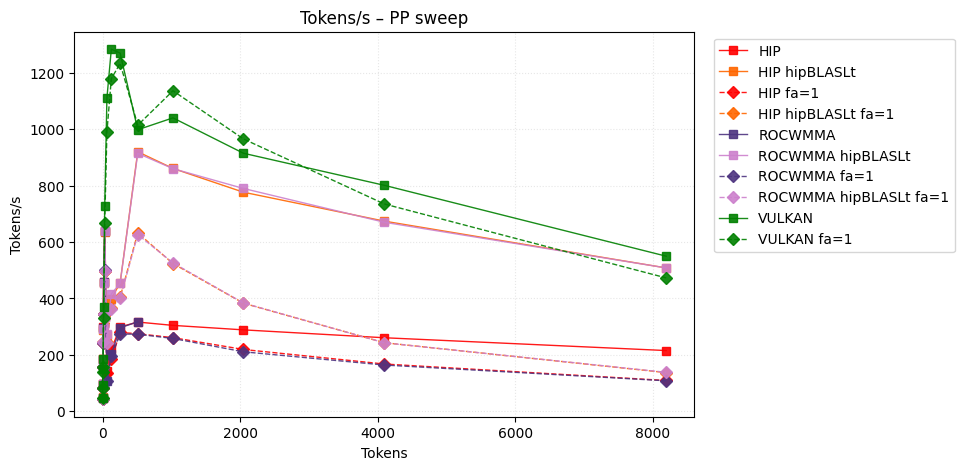

In [54]:
plot_mode(df, 'pp')

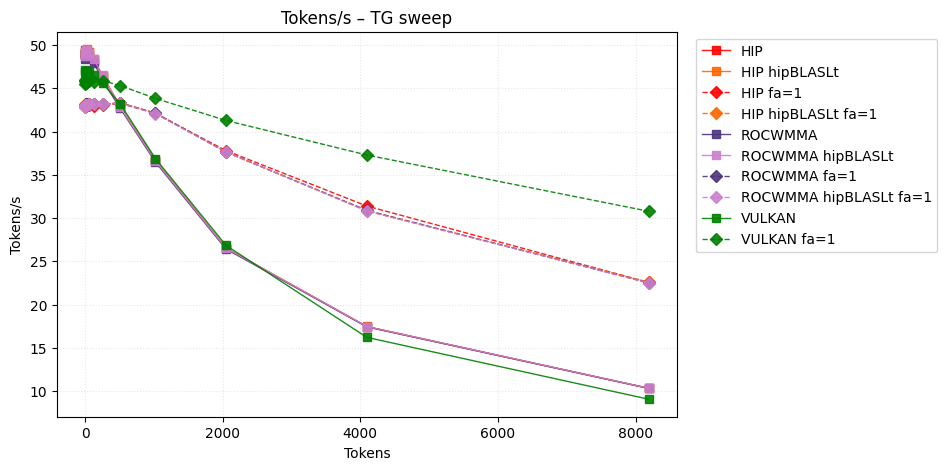

In [55]:
plot_mode(df, 'tg')